# Chaîne d'approvisionnement du secteur bovin.

Ce code permet d'observer l'évolution de la chaîne d'approvisionnement du secteur bovin entre 1995 et 2022.

In [1]:
#importations des librairies
import pymrio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import os
import imageio

### Choix des industries et des régions.

Nous avons classer les industries presentes dans les bases de données EXIOBASE3 avec la classification des industries qu'utilise les Nations-Unis avec l'International Standard Industrial Classification of All Economic Activities (ISIC). Nous avons utilisé pour classer les industries leur Révision 4 publiée en 2008 que vous pouvez trouver [ici](https://unstats.un.org/unsd/classifications/Econ/Download/In%20Text/ISIC_Rev_4_publication_French.pdf).

Vous pouvez la égalment consulter la classifications des industries presentes dans EXIOBASE3 que nous avons faites ici.

Afin d'observer la chaîne d'approvisionnement du secteur bovin, nous avons pré-selectionné des types d'industries qui nous intéresse et qui nous semble pertinent pour étudier les besoins nécessaires à pour la production du secteur bovin.

Pour cela, nous avons réunis dans le type d'industrie ISIC-A qui correspond aux activités de l

Expliquer pourquoi on a sélectionné ces secteurs

In [2]:
#Listes des secteurs qui nous intéressent
#Utilisation de la classification des industries des Nations Unies, l'International Standard Industrial Classification of All Economic Activities (ISIC).

#ISIC-A: Agriculture, sylviculture et pêche
Agri_For_Fish = [ 'Cultivation of wheat', 'Cultivation of cereal grains nec', 
                 'Cultivation of vegetables, fruit, nuts',  
                 'Cultivation of crops nec']

#ISIC-C: Activités de fabrication
Manufacturing_Food = ['Production of meat products nec',
					'Processing vegetable oils and fats',
					'Processing of dairy products',
					'Processing of Food products nec',
					'Manufacture of beverages',
                    'Processing of meat cattle']				

Manufacture = ['Manufacture of machinery and equipment n.e.c. (29)',		
						'Manufacture of electrical machinery and apparatus n.e.c. (31)',		
						'Manufacture of motor vehicles, trailers and semi-trailers (34)',	
						'Manufacture of other transport equipment (35)',	
						'Manufacture of furniture; manufacturing n.e.c. (36)']

#ISIC-D: Production et distribution d’électricité, de gaz, de vapeur et climatisation
Elec_gas_steam_air = ['Production of electricity by coal',
						'Production of electricity by gas',		
						'Production of electricity by petroleum and other oil derivatives',	
						'Production of electricity by biomass and waste',	
						'Production of electricity by solar photovoltaic',
						'Transmission of electricity',	
						'Distribution and trade of electricity',
						'Collection, purification and distribution of water (41)']

#ISIC-H: Transport et entreposage
Land_Transport = ['Transport via railways',
	'Other land transport', 'Supporting and auxiliary transport activities; activities of travel agencies (63)',
	'Post and telecommunications (64)']

#SIC-K/L/M: Activités financières et d’assurances/Activités immobilières/Activités professionnelles, scientifiques et techniques
Financial_insur_state = ['Financial intermediation, except insurance and pension funding (65)',	
						'Insurance and pension funding, except compulsory social security (66)',	
						'Activities auxiliary to financial intermediation (67)',	
						'Real estate activities (70)',	
						'Renting of machinery and equipment without operator and of personal and household goods (71)',
						'Computer and related activities (72)',	
						'Research and development (73)',	
						'Other business activities (74)']


Pouquoi avoir sélectionnée ces pays

In [3]:
#Liste des régions qui nous interessent 
regions = ['FR', 'DE', 'IT', 'ES']

### Nettoyage de l'inverse de la matrice de Leontief

Que represente la matrice inverse de Leontief

In [4]:
#Creation de la fonction 'load'
def load(year, regions, Agri_For_Fish, Manufacturing_Food, Manufacture, Financial_insur_state, Land_Transport, Elec_gas_steam_air):
    #Chargement des bases de données EXIOBASE3
    path = f"C:/Master 1/Stage/EXIOBASE3/IOT_{year}_ixi.zip"
    exio3 = pymrio.parse_exiobase3(path=path)

    #Commande pymrio qui permet de compléter les parties manquantes de EXIOBASE3
    exio3.calc_all()

    #Utilisation des fonctions Pymrio pour calculer les matrices x et A
    x = pymrio.calc_x(Z=exio3.Z, Y=exio3.Y)
    A = pymrio.calc_A(Z=exio3.Z, x=x)
    
    #Matrice identité de la même taille que la matrice A
    I = np.identity(A.shape[0])

    #Calcul de l'inverse de (I-A): permet d'obtenir la matrice inverse de Leontief
    inv = np.linalg.inv(I - A)

    #Transformation de 'inv' en DataFrame avec le noms des axes correspondant
    dfinv = pd.DataFrame(inv, index=A.index, columns=A.columns)

    #Multindex: pour les colonnes garde uniquement les secteurs 'Cattle farming' pour toutes les régions
    dfinv = dfinv.loc[:, (slice(None), 'Cattle farming')] 

    #Fonction pour filtrer les DataFrames par secteur et région
    def filter(dfinv, regions, sectors):
        #Liste vide
        df_list = []
        #Creation d'une boucle pour chaque région
        for region in regions:
            #Filtrer les lignes avec les régions qui nous intéressent 
            df_region = dfinv.loc[dfinv.index.get_level_values('region') == region] 
            #Filtrer les lignes avec les secteurs qui nous intéressent 
            df_region_filtered = df_region[df_region.index.get_level_values('sector').isin(sectors)]
            #La DataFrame crée pour une région de la boucle est ajoutée à la liste 'df_list'
            df_list.append(df_region_filtered)
            #Concatener les résultats filtrer en une seule DataFrame
        return pd.concat(df_list).loc[:, regions]

    #Applique la fonction à tous les types de secteurs
    dfinv_UE = filter(dfinv, regions, Agri_For_Fish)
    df1inv_UE = filter(dfinv, regions, Manufacturing_Food)
    df2inv_UE = filter(dfinv, regions, Manufacture)
    df3inv_UE = filter(dfinv, regions, Financial_insur_state)
    df4inv_UE = filter(dfinv, regions, Land_Transport)
    df5inv_UE = filter(dfinv, regions, Elec_gas_steam_air)

    #Résultat de la fonction 'load'
    return dfinv_UE, df1inv_UE, df2inv_UE, df3inv_UE, df4inv_UE, df5inv_UE


In [28]:
#Chargement des DataFrame
dfinv_UE, df1inv_UE, df2inv_UE, df3inv_UE, df4inv_UE, df5inv_UE = load(1995, regions, Agri_For_Fish, Manufacturing_Food, Manufacture, Financial_insur_state, Land_Transport, Elec_gas_steam_air)

c:\Users\Marie\anaconda3\Lib\site-packages\pymrio\core\mriosystem.py:900: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  Y_agg = Y.groupby(level="region", axis=1, sort=False).sum()
c:\Users\Marie\anaconda3\Lib\site-packages\pymrio\core\mriosystem.py:956: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  F_Y_agg = self.F_Y.groupby(level="region", axis=1, sort=False).sum()
c:\Users\Marie\anaconda3\Lib\site-packages\pymrio\core\mriosystem.py:900: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  Y_agg = Y.groupby(level="region", axis=1, sort=False).sum()
c:\Users\Marie\anaconda3\Lib\site-packages\pymrio\core\mriosystem.py:956: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  F_Y_agg = self.F_Y.groupby(level="region", axis=1, sort=False).sum()


### Création de cartes thermiques pour chaque type de secteur.

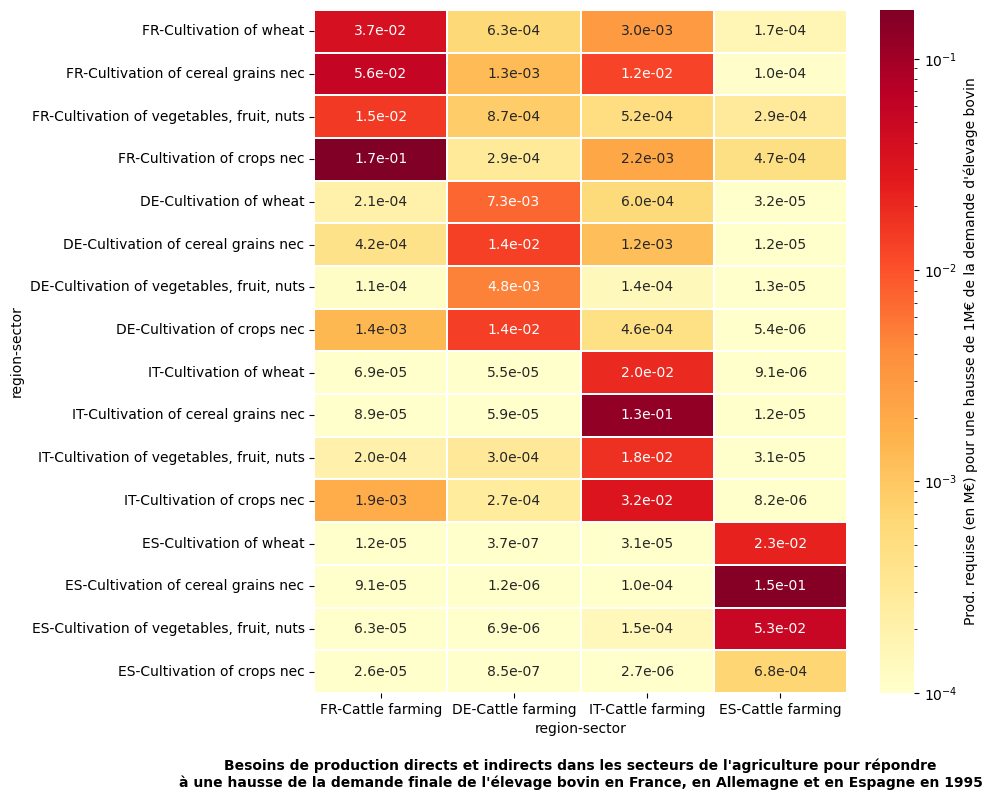

In [6]:
#Heatmap pour le type d'industrie ISIC-A
#Creation d'un répetoires pour enregistrer les heatmap
os.makedirs('Chaine_Approv_Agri', exist_ok=True)

#Modifier la taille de la figure
plt.figure(figsize=(10, 8))

#Fonction pour avoir des notations scientifiques
def scientific_notation(x, pos):
    return f'{x:.1e}'

#Création d'une carte thermique des DataFrames
sns.heatmap(dfinv_UE, norm=LogNorm(vmin=1E-04, vmax=1.7E-01),
                annot=True, fmt='.1e', cmap='YlOrRd', linewidths=0.1,
                cbar_kws={'label': "Prod. requise (en M€) pour une hausse de 1M€ de la demande d'élevage bovin"},
                annot_kws={"size": 10}) 

#Titre de la carte thermique
plt.title(f"Besoins de production directs et indirects dans les secteurs de l'agriculture pour répondre\nà une hausse de la demande finale de l'élevage bovin en France, en Allemagne et en Espagne en 1995", fontsize=10, fontweight='bold', y=-0.15)

#Ajuster l'espacements des éléments de la carte thermique
plt.tight_layout()

#Sauvegarder la carte de thermique
frame_filename = f"C:\Master 1\exiobase3-manipulation\Secteur bovin - Chaîne d'Approvisionnement\Heatmap_CattleFarming\ISIC-A_Agriculture\Agri_1995.png"
plt.savefig(frame_filename, bbox_inches='tight')

#Pour fermer la carte thermique
plt.show()

Mise en log petite valeur

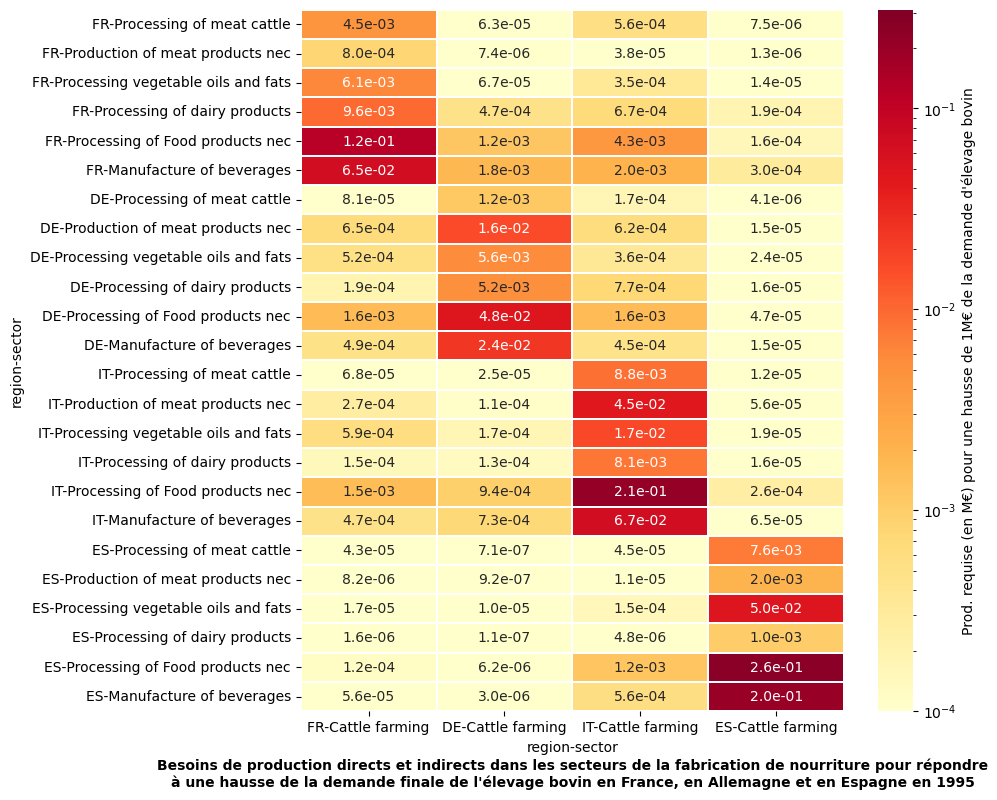

In [7]:
#Heatmap pour le type d'industrie ISIC-C
#Creation d'un répetoires pour enregistrer les heatmap
os.makedirs('Chaine_Approv_ManuFood', exist_ok=True)

#Modifier la taille de la figure
plt.figure(figsize=(10, 8))

#Fonction pour avoir des notations scientifiques
def scientific_notation(x, pos):
    return f'{x:.1e}'

#Création d'une carte thermique des DataFrames
sns.heatmap(df1inv_UE, norm=LogNorm(vmin=1E-04, vmax=3.1E-01),
                annot=True, fmt='.1e', cmap='YlOrRd', linewidths=0.1,
                cbar_kws={'label': "Prod. requise (en M€) pour une hausse de 1M€ de la demande d'élevage bovin"},
                annot_kws={"size": 10}) 

#Ajuster l'espacements des éléments de la carte thermique
plt.title(f"Besoins de production directs et indirects dans les secteurs de la fabrication de nourriture pour répondre\nà une hausse de la demande finale de l'élevage bovin en France, en Allemagne et en Espagne en 1995.", fontsize=10, fontweight='bold', y=-0.12)

#Ajuster l'espacements des éléments de la carte thermique
plt.tight_layout()

#Sauvegarder la carte de thermique
frame_filename = f"C:\Master 1\exiobase3-manipulation\Secteur bovin - Chaîne d'Approvisionnement\Heatmap_CattleFarming\ISIC-C_ManuFood\ManuFood_1995.png"
plt.savefig(frame_filename, bbox_inches='tight')

#Pour fermer la carte thermique
plt.show()

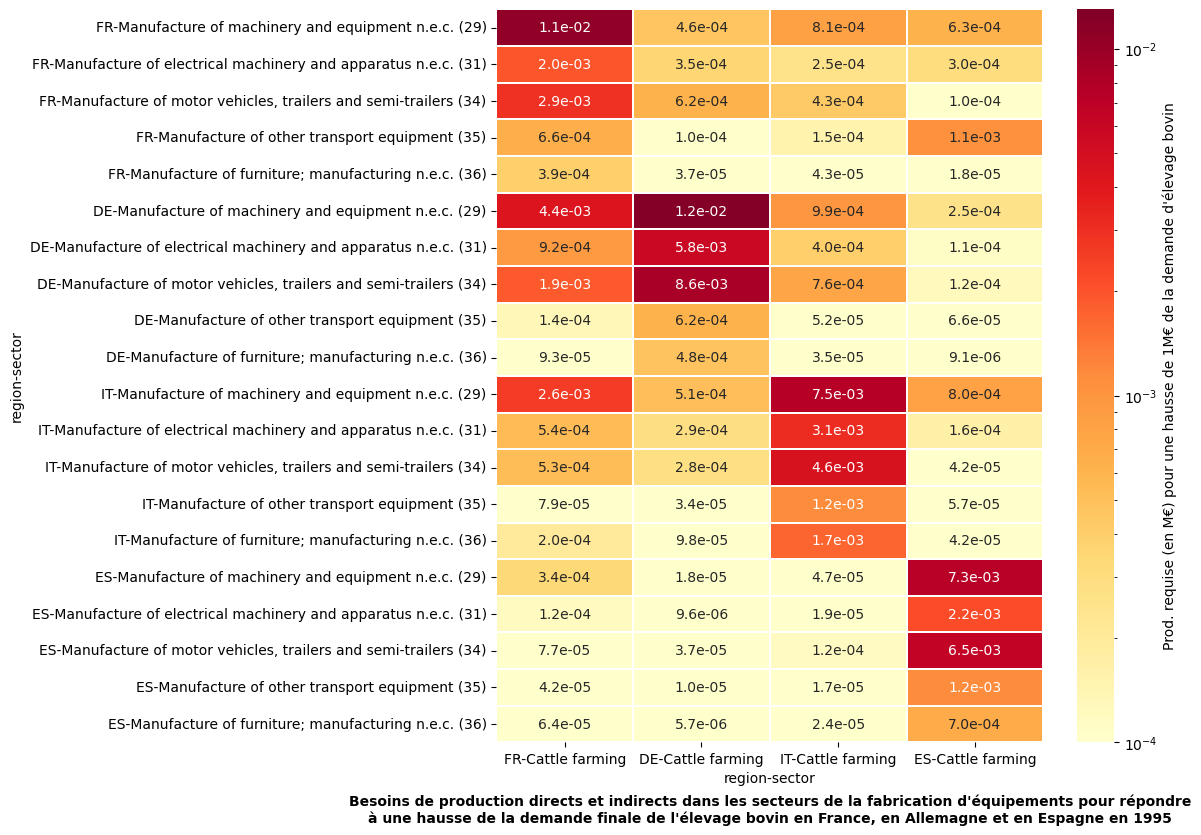

In [31]:
#Heatmap pour le type d'industrie ISIC-C
#Creation d'un répetoires pour enregistrer les heatmap
os.makedirs('Chaine_Approv_Manufacture', exist_ok=True)

#Modifier la taille de la figure
plt.figure(figsize=(12, 10))

#Fonction pour avoir des notations scientifiques
def scientific_notation(x, pos):
    return f'{x:.1e}'

#Création d'une carte thermique des DataFrames
sns.heatmap(df2inv_UE, norm=LogNorm(vmin=1E-04, vmax=1.3E-02),
                annot=True, fmt='.1e', cmap='YlOrRd', linewidths=0.1,
                cbar_kws={'label': "Prod. requise (en M€) pour une hausse de 1M€ de la demande d'élevage bovin"},
                annot_kws={"size": 10}) 

#Ajuster l'espacements des éléments de la carte thermique
plt.title(f"Besoins de production directs et indirects dans les secteurs de la fabrication d'équipements pour répondre\nà une hausse de la demande finale de l'élevage bovin en France, en Allemagne et en Espagne en 1995.", fontsize=10, fontweight='bold', y=-0.12)

#Ajuster l'espacements des éléments de la carte thermique
plt.tight_layout(rect=[0, 0.1, 1, 0.95])

#Sauvegarder la carte de thermique
frame_filename = f"C:\Master 1\exiobase3-manipulation\Secteur bovin - Chaîne d'Approvisionnement\Heatmap_CattleFarming\ISIC-C_Manufacture\Manufacture_1995.png"
plt.savefig(frame_filename, bbox_inches='tight')

#Pour fermer la carte thermique
plt.show()

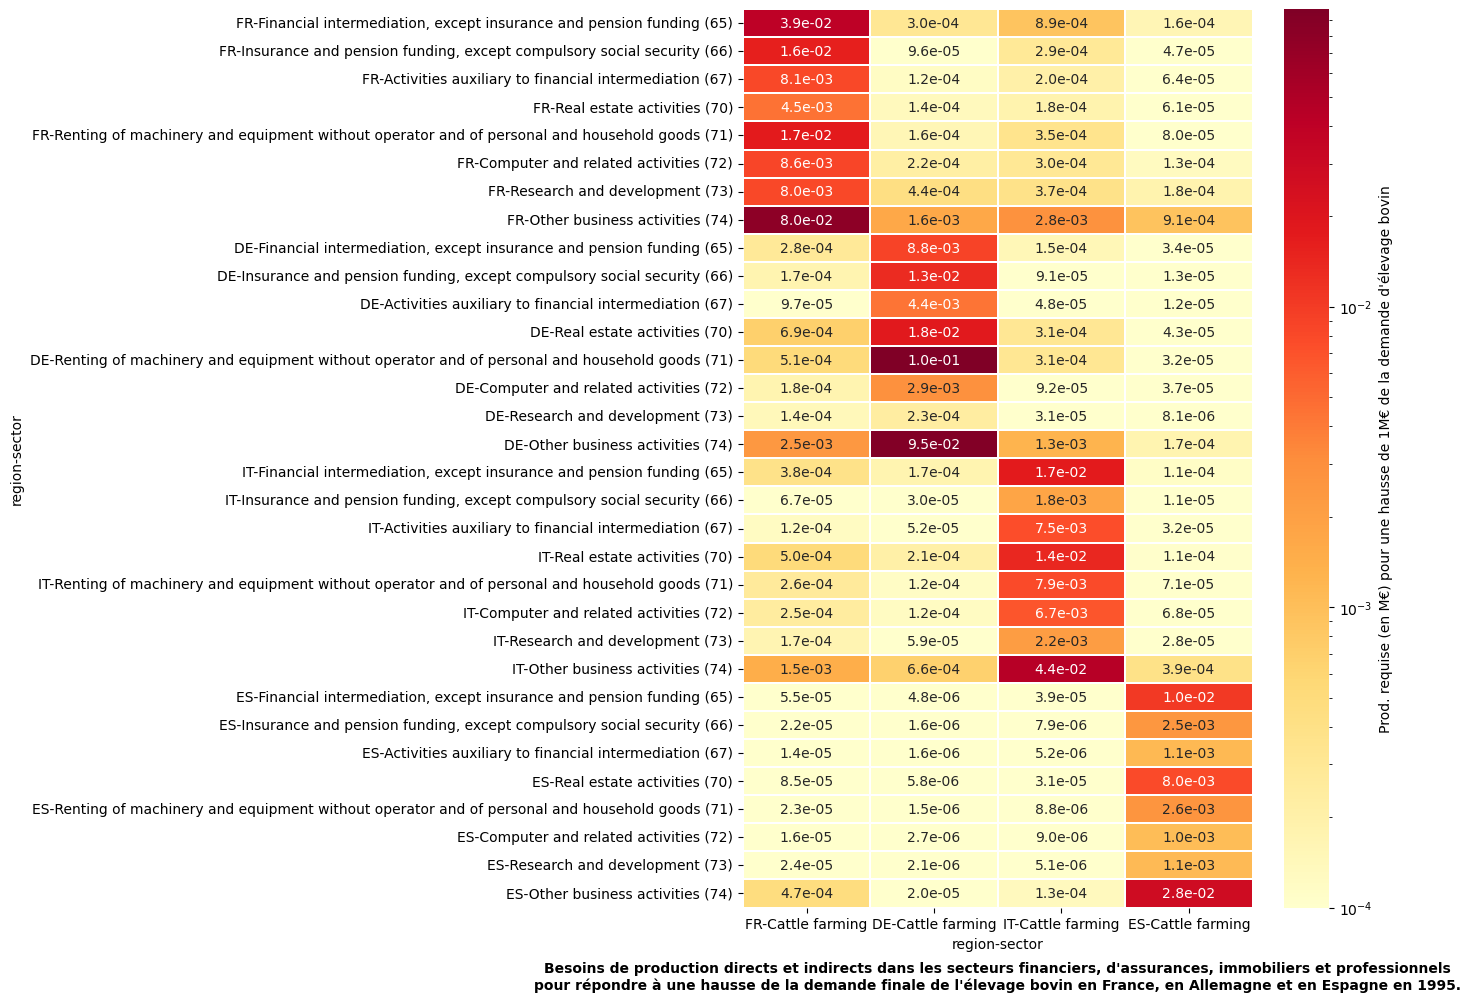

In [38]:
#Heatmap pour le type d'industrie ISIC-K/L/M
#Creation d'un répetoires pour enregistrer les heatmap
os.makedirs('Chaine_Approv_Finance', exist_ok=True)

#Modifier la taille de la figure
plt.figure(figsize=(14, 10))

#Fonction pour avoir des notations scientifiques
def scientific_notation(x, pos):
    return f'{x:.1e}'

#Création d'une carte thermique des DataFrames
sns.heatmap(df3inv_UE, norm=LogNorm(vmin=1E-04, vmax=9.8E-02),
                annot=True, fmt='.1e', cmap='YlOrRd', linewidths=0.1,
                cbar_kws={'label': "Prod. requise (en M€) pour une hausse de 1M€ de la demande d'élevage bovin"},
                annot_kws={"size": 10}) 

#Ajuster l'espacements des éléments de la carte thermique
plt.title(f"Besoins de production directs et indirects dans les secteurs financiers, d'assurances, immobiliers et professionnels\npour répondre à une hausse de la demande finale de l'élevage bovin en France, en Allemagne et en Espagne en 1995.", fontsize=10, fontweight='bold', y=-0.10)

#Ajuster l'espacements des éléments de la carte thermique
plt.tight_layout()

#Sauvegarder la carte de thermique
frame_filename = f"C:\Master 1\exiobase3-manipulation\Secteur bovin - Chaîne d'Approvisionnement\Heatmap_CattleFarming\ISIC-KLM_Fin_Immo\Financial_1995.png"
plt.savefig(frame_filename, bbox_inches='tight')

#Pour fermer la carte thermique
plt.show()

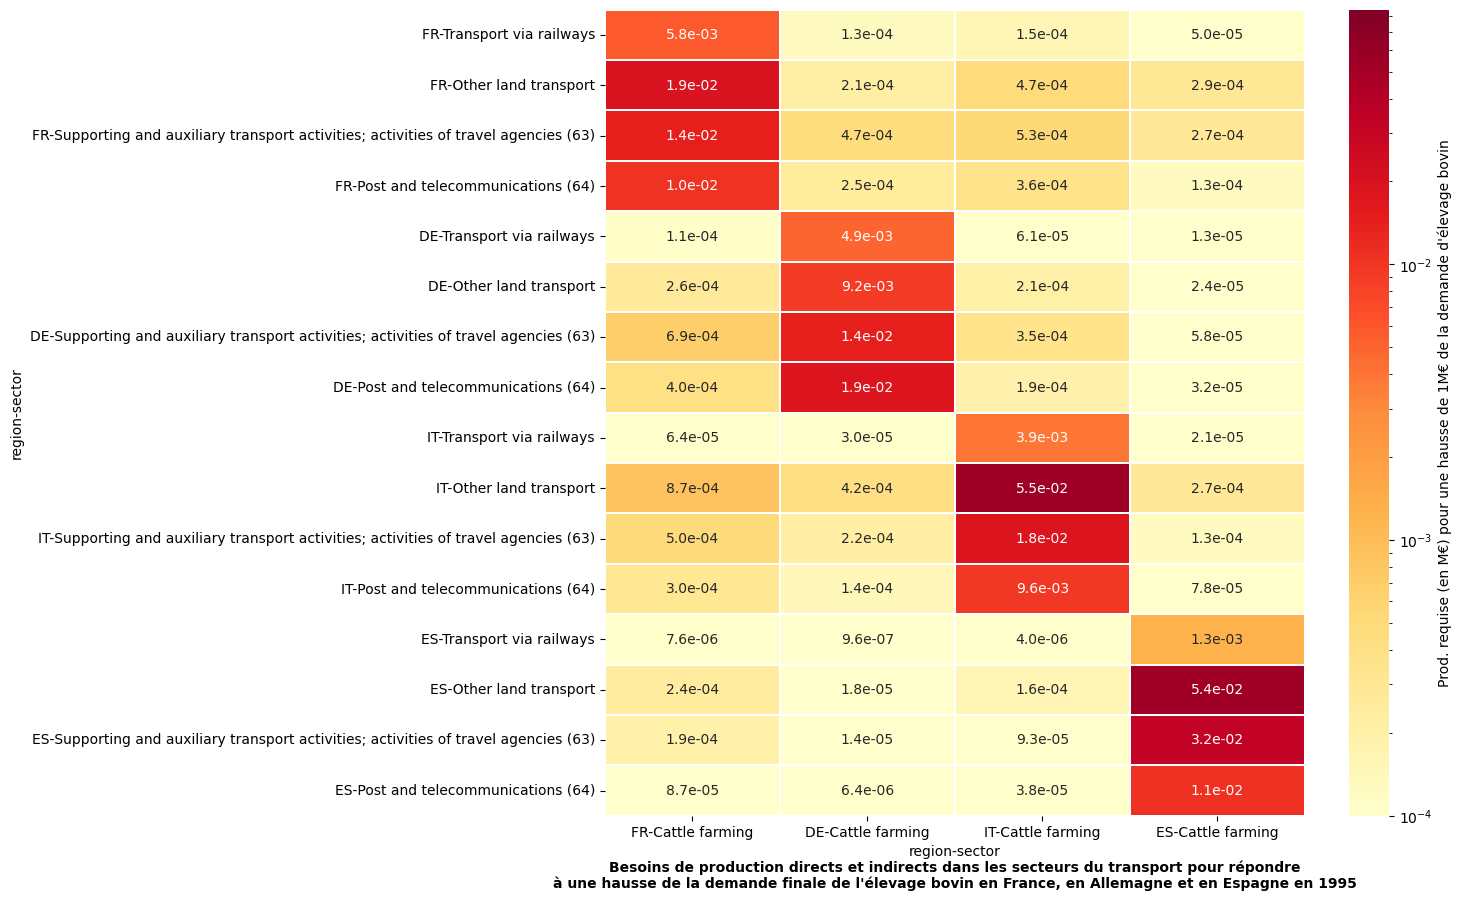

In [12]:
#Heatmap pour le type d'industrie ISIC-H
#Creation d'un répetoires pour enregistrer les heatmap
os.makedirs('Chaine_Approv_Transport', exist_ok=True)

#Modifier la taille de la figure
plt.figure(figsize=(15, 9))

#Fonction pour avoir des notations scientifiques
def scientific_notation(x, pos):
    return f'{x:.1e}'

#Création d'une carte thermique des DataFrames
sns.heatmap(df4inv_UE, norm=LogNorm(vmin=1E-04, vmax=8.4E-02),
                annot=True, fmt='.1e', cmap='YlOrRd', linewidths=0.1,
                cbar_kws={'label': "Prod. requise (en M€) pour une hausse de 1M€ de la demande d'élevage bovin"},
                annot_kws={"size": 10}) 

#Ajuster l'espacements des éléments de la carte thermique
plt.title(f"Besoins de production directs et indirects dans les secteurs du transport pour répondre\nà une hausse de la demande finale de l'élevage bovin en France, en Allemagne et en Espagne en 1995", fontsize=10, fontweight='bold', y=-0.10)

#Ajuster l'espacements des éléments de la carte thermique
plt.tight_layout()

#Sauvegarder la carte de thermique
frame_filename = f"C:\Master 1\exiobase3-manipulation\Secteur bovin - Chaîne d'Approvisionnement\Heatmap_CattleFarming\ISIC-H_Transport\Transport_1995.png"
plt.savefig(frame_filename, bbox_inches='tight')

#Pour fermer la carte thermique
plt.show()

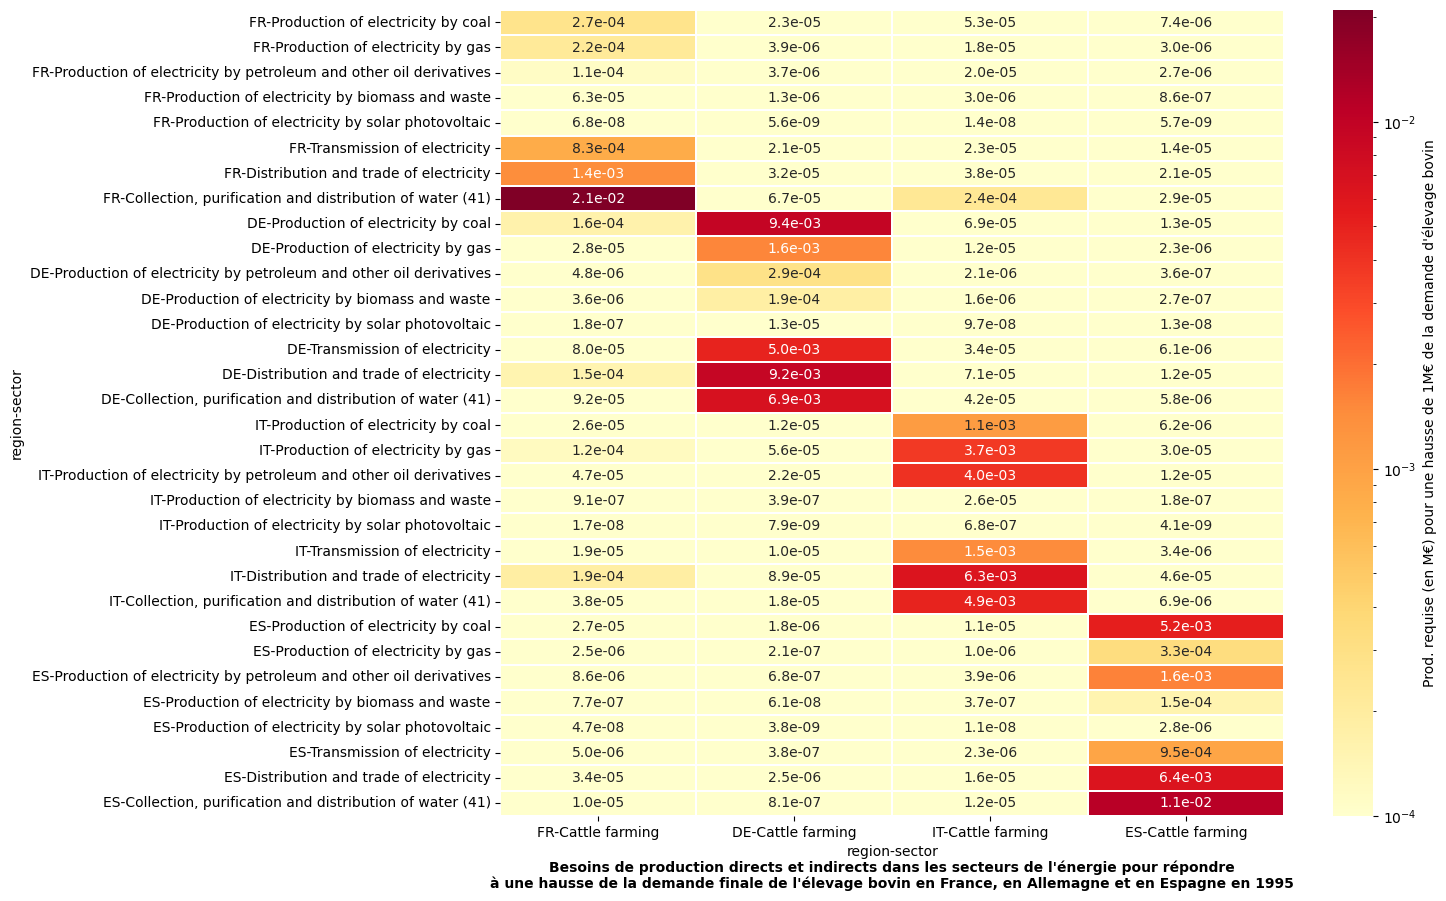

In [13]:
#Heatmap pour le type d'industrie ISIC-D
#Creation d'un répetoires pour enregistrer les heatmap
os.makedirs('Chaine_Approv_Energy', exist_ok=True)

#Modifier la taille de la figure
plt.figure(figsize=(15, 9))

#Fonction pour avoir des notations scientifiques
def scientific_notation(x, pos):
    return f'{x:.1e}'

#Création d'une carte thermique des DataFrames
sns.heatmap(df5inv_UE, norm=LogNorm(vmin=1E-04, vmax=2.1E-02),
                annot=True, fmt='.1e', cmap='YlOrRd', linewidths=0.1,
                cbar_kws={'label': "Prod. requise (en M€) pour une hausse de 1M€ de la demande d'élevage bovin"},
                annot_kws={"size": 10}) 

#Ajuster l'espacements des éléments de la carte thermique
plt.title(f"Besoins de production directs et indirects dans les secteurs de l'énergie pour répondre\nà une hausse de la demande finale de l'élevage bovin en France, en Allemagne et en Espagne en 1995", fontsize=10, fontweight='bold', y=-0.10)

#Ajuster l'espacements des éléments de la carte thermique
plt.tight_layout()

#Sauvegarder la carte de thermique
frame_filename = f"C:\Master 1\exiobase3-manipulation\Secteur bovin - Chaîne d'Approvisionnement\Heatmap_CattleFarming\ISIC-D_Energy\Energy_1995.png"
plt.savefig(frame_filename, bbox_inches='tight')

#Afficher la heatmap
plt.show()


In [19]:
dfinv_UE, df1inv_UE, df2inv_UE, df3inv_UE, df4inv_UE, df5inv_UE = load(2022, regions, Agri_For_Fish, Manufacturing_Food, Manufacture, Financial_insur_state, Land_Transport, Elec_gas_steam_air)

c:\Users\Marie\anaconda3\Lib\site-packages\pymrio\core\mriosystem.py:900: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  Y_agg = Y.groupby(level="region", axis=1, sort=False).sum()
c:\Users\Marie\anaconda3\Lib\site-packages\pymrio\core\mriosystem.py:956: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  F_Y_agg = self.F_Y.groupby(level="region", axis=1, sort=False).sum()
c:\Users\Marie\anaconda3\Lib\site-packages\pymrio\core\mriosystem.py:900: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  Y_agg = Y.groupby(level="region", axis=1, sort=False).sum()
c:\Users\Marie\anaconda3\Lib\site-packages\pymrio\core\mriosystem.py:956: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  F_Y_agg = self.F_Y.groupby(level="region", axis=1, sort=False).sum()


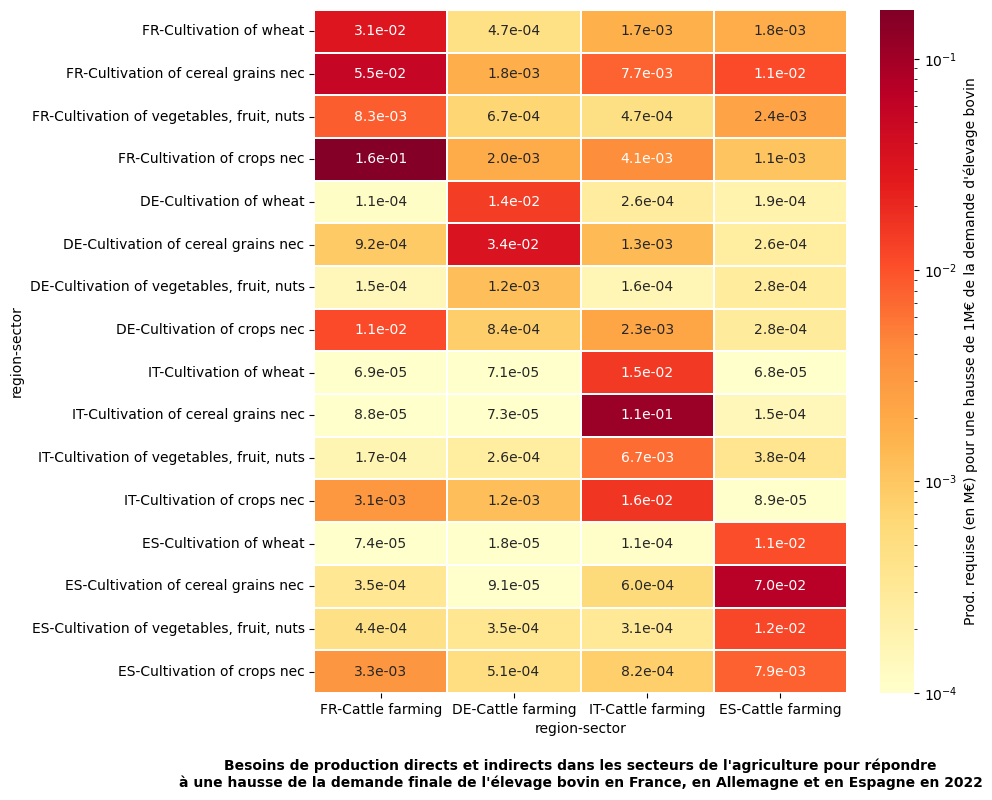

In [20]:
#Modifier la taille de la carte thermique
plt.figure(figsize=(10, 8))

#Notation scientifique
def scientific_notation(x, pos):
    return f'{x:.1e}'

#Création d'une carte thermique des DataFrames
sns.heatmap(dfinv_UE, norm=LogNorm(vmin=1E-04, vmax=1.7E-01),
                annot=True, fmt='.1e', cmap='YlOrRd', linewidths=0.1,
                cbar_kws={'label': "Prod. requise (en M€) pour une hausse de 1M€ de la demande d'élevage bovin"},
                annot_kws={"size": 10}) 

#Titre de la carte thermique
plt.title(f"Besoins de production directs et indirects dans les secteurs de l'agriculture pour répondre\nà une hausse de la demande finale de l'élevage bovin en France, en Allemagne et en Espagne en 2022", fontsize=10, fontweight='bold', y=-0.15)

#Ajuster l'espacements des éléments de la carte thermique
plt.tight_layout()

#Sauvegarder la heatmap
frame_filename = f"C:\Master 1\exiobase3-manipulation\Secteur bovin - Chaîne d'Approvisionnement\Heatmap_CattleFarming\ISIC-A_Agriculture\Agri_2022.png"
plt.savefig(frame_filename, bbox_inches='tight')

#Ne pas afficher la heatmap
plt.show()

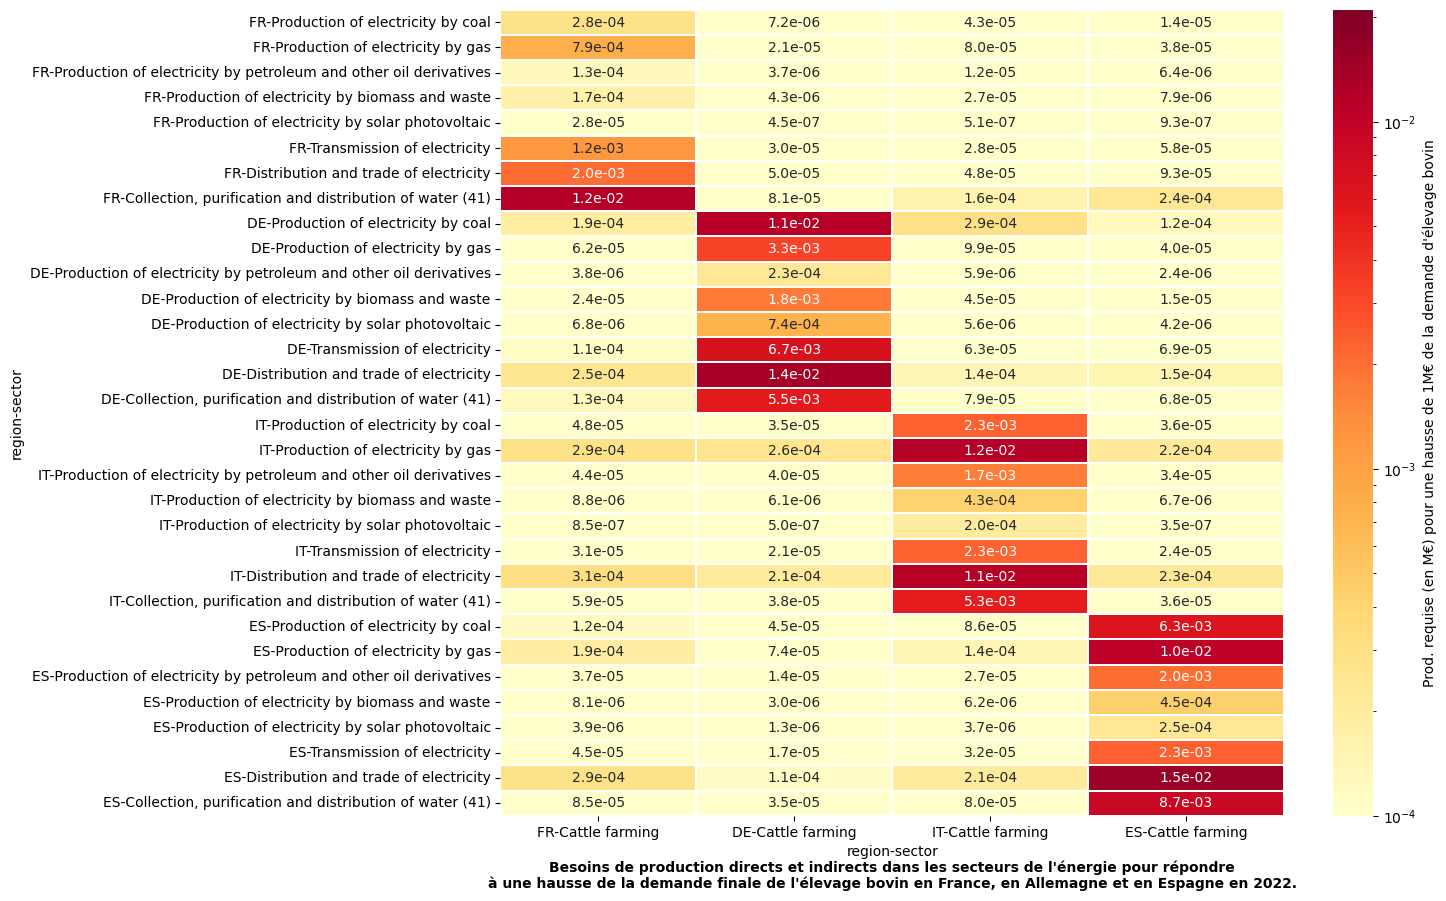

In [27]:
plt.figure(figsize=(10, 8))

# Define a custom formatter function for scientific notation
def scientific_notation(x, pos):
    return f'{x:.1e}'

sns.heatmap(df1inv_UE, norm=LogNorm(vmin=1E-04, vmax=3.1E-01),
                annot=True, fmt='.1e', cmap='YlOrRd', linewidths=0.1,
                cbar_kws={'label': "Prod. requise (en M€) pour une hausse de 1M€ de la demande d'élevage bovin"},
                annot_kws={"size": 10}) # Adjust size and weight as needed
plt.title(f"Besoins de production directs et indirects dans les secteurs de la fabrication de nourriture pour répondre\nà une hausse de la demande finale de l'élevage bovin en France, en Allemagne et en Espagne en 2022.", fontsize=10, fontweight='bold', y=-0.12)

plt.tight_layout()

# Use raw string to handle the backslash in Windows file paths
frame_filename = f"C:\Master 1\exiobase3-manipulation\Secteur bovin - Chaîne d'Approvisionnement\Heatmap_CattleFarming\ISIC-C_ManuFood\ManuFood_2022.png"
plt.savefig(frame_filename, bbox_inches='tight')
plt.close()


plt.figure(figsize=(12, 10))

# Define a custom formatter function for scientific notation
def scientific_notation(x, pos):
    return f'{x:.1e}'

sns.heatmap(df2inv_UE, norm=LogNorm(vmin=1E-04, vmax=1.3E-02),
                annot=True, fmt='.1e', cmap='YlOrRd', linewidths=0.1,
                cbar_kws={'label': "Prod. requise (en M€) pour une hausse de 1M€ de la demande d'élevage bovin"},
                annot_kws={"size": 10}) # Adjust size and weight as needed
plt.title(f"Besoins de production directs et indirects dans les secteurs de la fabrication d'équipements pour répondre\nà une hausse de la demande finale de l'élevage bovin en France, en Allemagne et en Espagne en 2022.", fontsize=10, fontweight='bold', y=-0.12)

plt.tight_layout(rect=[0, 0.1, 1, 0.95])

# Use raw string to handle the backslash in Windows file paths
frame_filename = f"C:\Master 1\exiobase3-manipulation\Secteur bovin - Chaîne d'Approvisionnement\Heatmap_CattleFarming\ISIC-C_Manufacture\Manufacture_2022.png"
plt.savefig(frame_filename, bbox_inches='tight')
plt.close()


plt.figure(figsize=(14, 10))

# Define a custom formatter function for scientific notation
def scientific_notation(x, pos):
    return f'{x:.1e}'

sns.heatmap(df3inv_UE, norm=LogNorm(vmin=1E-04, vmax=9.8E-02),
                annot=True, fmt='.1e', cmap='YlOrRd', linewidths=0.1,
                cbar_kws={'label': "Prod. requise (en M€) pour une hausse de 1M€ de la demande d'élevage bovin"},
                annot_kws={"size": 10}) # Adjust size and weight as needed
plt.title(f"Besoins de production directs et indirects dans les secteurs financiers, d'assurances, immobiliers et professionnels\npour répondre à une hausse de la demande finale de l'élevage bovin en France, en Allemagne et en Espagne en 2022.", fontsize=10, fontweight='bold', y=-0.1)

plt.tight_layout()

# Use raw string to handle the backslash in Windows file paths
frame_filename = f"C:\Master 1\exiobase3-manipulation\Secteur bovin - Chaîne d'Approvisionnement\Heatmap_CattleFarming\ISIC-KLM_Fin_Immo\Financial_2022.png"
plt.savefig(frame_filename, bbox_inches='tight')
plt.close()


plt.figure(figsize=(15, 9))

# Define a custom formatter function for scientific notation
def scientific_notation(x, pos):
    return f'{x:.1e}'

sns.heatmap(df4inv_UE, norm=LogNorm(vmin=1E-04, vmax=8.4E-02),
                annot=True, fmt='.1e', cmap='YlOrRd', linewidths=0.1,
                cbar_kws={'label': "Prod. requise (en M€) pour une hausse de 1M€ de la demande d'élevage bovin"},
                annot_kws={"size": 10}) # Adjust size and weight as needed
plt.title(f"Besoins de production directs et indirects dans les secteurs du transport pour répondre\nà une hausse de la demande finale de l'élevage bovin en France, en Allemagne et en Espagne en 2022.", fontsize=10, fontweight='bold', y=-0.10)

plt.tight_layout()

# Use raw string to handle the backslash in Windows file paths
frame_filename = f"C:\Master 1\exiobase3-manipulation\Secteur bovin - Chaîne d'Approvisionnement\Heatmap_CattleFarming\ISIC-H_Transport\Transport_2022.png"
plt.savefig(frame_filename, bbox_inches='tight')
plt.close()


plt.figure(figsize=(15, 9))

# Define a custom formatter function for scientific notation
def scientific_notation(x, pos):
    return f'{x:.1e}'

sns.heatmap(df5inv_UE, norm=LogNorm(vmin=1E-04, vmax=2.1E-02),
                annot=True, fmt='.1e', cmap='YlOrRd', linewidths=0.1,
                cbar_kws={'label': "Prod. requise (en M€) pour une hausse de 1M€ de la demande d'élevage bovin"},
                annot_kws={"size": 10}) # Adjust size and weight as needed
plt.title(f"Besoins de production directs et indirects dans les secteurs de l'énergie pour répondre\nà une hausse de la demande finale de l'élevage bovin en France, en Allemagne et en Espagne en 2022.", fontsize=10, fontweight='bold', y=-0.10)

plt.tight_layout()

# Use raw string to handle the backslash in Windows file paths
frame_filename = f"C:\Master 1\exiobase3-manipulation\Secteur bovin - Chaîne d'Approvisionnement\Heatmap_CattleFarming\ISIC-D_Energy\Energy_2022.png"
plt.savefig(frame_filename, bbox_inches='tight')
plt.show()


### Création d'un GIF

In [32]:
#Liste vide pour stocker les images créées
images = []

#Liste des chemins des heatmaps
chemins = [f"C:\Master 1\exiobase3-manipulation\Secteur bovin - Chaîne d'Approvisionnement\Heatmap_CattleFarming\ISIC-A_Agriculture\Agri_1995.png",
    f"C:\Master 1\exiobase3-manipulation\Secteur bovin - Chaîne d'Approvisionnement\Heatmap_CattleFarming\ISIC-A_Agriculture\Agri_2022.png"]

#Boucle pour charger chaque chemin de la liste
for chemin in chemins:
    images.append(imageio.imread(chemin))

#Nom du fichier GIF
filename = 'Heatmap_Chain_Approv_Agri.gif'

#Enregistrer le GIF
imageio.mimsave(filename, images, duration=1000, loop=0)


C:\Users\Marie\AppData\Local\Temp\ipykernel_35620\4277563940.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(chemin))


In [33]:
# Create a list to hold the images
images = []

# List of file paths for the heatmaps
image_paths = [f"C:\Master 1\exiobase3-manipulation\Secteur bovin - Chaîne d'Approvisionnement\Heatmap_CattleFarming\ISIC-C_ManuFood\ManuFood_1995.png",
    f"C:\Master 1\exiobase3-manipulation\Secteur bovin - Chaîne d'Approvisionnement\Heatmap_CattleFarming\ISIC-C_ManuFood\ManuFood_2022.png"]

# Load each image and append to the list
for path in image_paths:
    images.append(imageio.imread(path))

# Save the images as a GIF
filename = 'Heatmap_Chain_Approv_ManuFood.gif'
imageio.mimsave(filename, images, duration=1000, loop=0)

C:\Users\Marie\AppData\Local\Temp\ipykernel_35620\1921756648.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(path))


In [34]:
# Create a list to hold the images
images = []

# List of file paths for the heatmaps
image_paths = [f"C:\Master 1\exiobase3-manipulation\Secteur bovin - Chaîne d'Approvisionnement\Heatmap_CattleFarming\ISIC-C_Manufacture\Manufacture_1995.png",
    f"C:\Master 1\exiobase3-manipulation\Secteur bovin - Chaîne d'Approvisionnement\Heatmap_CattleFarming\ISIC-C_Manufacture\Manufacture_2022.png"]

# Load each image and append to the list
for path in image_paths:
    images.append(imageio.imread(path))

# Save the images as a GIF
filename = 'Heatmap_Chain_Approv_Manufacture.gif'
imageio.mimsave(filename, images, duration=1000, loop=0)

C:\Users\Marie\AppData\Local\Temp\ipykernel_35620\1133303038.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(path))


In [39]:
# Create a list to hold the images
images = []

# List of file paths for the heatmaps
image_paths = [f"C:\Master 1\exiobase3-manipulation\Secteur bovin - Chaîne d'Approvisionnement\Heatmap_CattleFarming\ISIC-KLM_Fin_Immo\Financial_1995.png",
    f"C:\Master 1\exiobase3-manipulation\Secteur bovin - Chaîne d'Approvisionnement\Heatmap_CattleFarming\ISIC-KLM_Fin_Immo\Financial_2022.png"]

# Load each image and append to the list
for path in image_paths:
    images.append(imageio.imread(path))

# Save the images as a GIF
filename = 'Heatmap_Chain_Approv_Finance.gif'
imageio.mimsave(filename, images, duration=1000, loop=0)

C:\Users\Marie\AppData\Local\Temp\ipykernel_35620\1511452927.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(path))


In [36]:
# Create a list to hold the images
images = []

# List of file paths for the heatmaps
image_paths = [f"C:\Master 1\exiobase3-manipulation\Secteur bovin - Chaîne d'Approvisionnement\Heatmap_CattleFarming\ISIC-H_Transport\Transport_1995.png",
    f"C:\Master 1\exiobase3-manipulation\Secteur bovin - Chaîne d'Approvisionnement\Heatmap_CattleFarming\ISIC-H_Transport\Transport_2022.png"]

# Load each image and append to the list
for path in image_paths:
    images.append(imageio.imread(path))

# Save the images as a GIF
filename = 'Heatmap_Chain_Approv_Transport.gif'
imageio.mimsave(filename, images, duration=1000, loop=0)

C:\Users\Marie\AppData\Local\Temp\ipykernel_35620\3047614408.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(path))


In [37]:
# Create a list to hold the images
images = []

# List of file paths for the heatmaps
image_paths = [f"C:\Master 1\exiobase3-manipulation\Secteur bovin - Chaîne d'Approvisionnement\Heatmap_CattleFarming\ISIC-D_Energy\Energy_1995.png",
    f"C:\Master 1\exiobase3-manipulation\Secteur bovin - Chaîne d'Approvisionnement\Heatmap_CattleFarming\ISIC-D_Energy\Energy_2022.png"]

# Load each image and append to the list
for path in image_paths:
    images.append(imageio.imread(path))

# Save the images as a GIF
filename = 'Heatmap_Chain_Approv_Energy.gif'
imageio.mimsave(filename, images, duration=1000, loop=0)

C:\Users\Marie\AppData\Local\Temp\ipykernel_35620\2252047055.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(path))
